<a href="https://colab.research.google.com/github/Jarcos09/Tareas/blob/main/Visualizaci%C3%B3n_Equipo_29.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🎓 **Inteligencia Artificial Aplicada**

## 🤖 **Análisis de grandes volúmenes de datos (Gpo 10)**

### 🏛️ Tecnológico de Monterrey

#### 👨‍🏫 **Profesor titular :** Dr. Iván Olmos Pineda
#### 👩‍🏫 **Profesor asistente :** Verónica Sandra Guzmán de Valle

### 📊 **Actividad 5 | Visualización de Resultados**

#### 📅 **15 de junio de 2025**

### 👥 Equipo 29

* 🧑‍💻 **A01795941 :** Juan Carlos Pérez Nava
* 🧑‍💻 **A01016093 :** Oscar Enrique García García
* 🧑‍💻 **A01795164 :** Oscar Andrés Ponce Parra




In [46]:
# Módulos del sistema para manejo de rutas
import os
import sys

# 🔧 Definición del path para incluir una librería personalizada
# Se establece la ruta donde están almacenadas las librerías adicionales que se usarán en el proyecto.
module_path = os.path.abspath(os.path.join('proyectos/librerias'))
if module_path not in sys.path:
    sys.path.append(module_path)

# 🎨 Importación de módulos gráficos personalizados
# Se usa un módulo externo 'graficas' que contiene funciones para el calculo del IQR
from graficas import *

# 🏗️ Definición de estructuras de datos en PySpark
# Se importan los tipos de datos que se pueden utilizar en las tablas (DataFrame).
from pyspark.sql import (
    SparkSession, DataFrame
)

# 🏛️ Funciones SQL de PySpark para manipulación de datos
# Estas funciones permiten realizar operaciones como filtrado, agregación y transformación de datos.
from pyspark.sql.types import (
    StructType, StructField, StringType, IntegerType, DoubleType
)

# 🚀 Transformaciones de datos con PySpark ML
# Se importan herramientas para preprocesamiento, ingeniería de características y normalización.
from pyspark.sql.functions import (
    col, sum, avg, lit, count, when, format_number, round, rand, countDistinct,
    concat
)

# 🚀 Transformaciones de datos con PySpark ML
# Se importan herramientas para preprocesamiento, ingeniería de características y normalización.
from pyspark.ml.feature import (
    StringIndexer, OneHotEncoder, QuantileDiscretizer,
    VectorAssembler, StandardScaler, Imputer
)

# 📝 Fórmula para modelado en ML usando RFormula
# Simplifica la transformación de variables predictoras y objetivos en un solo paso.
from pyspark.ml.feature import RFormula

# 🌲 Importación del modelo RandomForestClassifier
from pyspark.ml.classification import RandomForestClassifier

# 🔎 Importación de K-Means para clustering
from pyspark.ml.clustering import KMeans

# 📊 Evaluación de modelos de Machine Learning
# Se importan métricas para evaluar la calidad de los modelos supervisados y no supervisados.
from pyspark.ml.evaluation import(    MulticlassClassificationEvaluator, ClusteringEvaluator
    )

# 🔄 Optimización de modelos mediante validación cruzada y búsqueda de hiperparámetros
from pyspark.ml.tuning import (
    ParamGridBuilder, CrossValidator
)

# 🎨 Importación de librerías para visualización de datos
import matplotlib.pyplot as plt
import seaborn as sns

# 📦 Librería para la integración con Kaggle
import kagglehub

# 🏗️ Manipulación de datos con Pandas
import pandas as pd
import numpy as np

# 🔄 Funciones de programación funcional en Python
# 'reduce' permite realizar operaciones acumulativas en estructuras de datos iterables.
from functools import reduce

In [3]:
path = kagglehub.dataset_download("sobhanmoosavi/us-accidents")
print("Path to dataset files:", path)

Path to dataset files: /home/jarcos/.cache/kagglehub/datasets/sobhanmoosavi/us-accidents/versions/13


In [4]:
# Creación de una sesión de Spark
# Se configura el modo "local[*]" para usar todos los núcleos disponibles en la máquina
# Se asigna un nombre a la aplicación y se configuran los límites de memoria para el driver y los ejecutores

spark = SparkSession.builder.master("local[*]").appName("metricas").config("spark.driver.memory", "40g").config("spark.executor.memory", "20g").getOrCreate()
df_accident = spark.read.option("header", True).option("inferSchema", True).csv(path)
spark.sparkContext.setLogLevel("ERROR")

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/06/13 23:16:15 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


# **1 - Definición de Validación Cruzada**

**Etapa 1: Feature Engineering**

A lo largo de las actividades, se han realizado particiones considerando, en primer lugar, la severidad del accidente y, posteriormente, las condiciones climáticas. En este ejercicio se analizará la frecuencia de dichas particiones para identificar combinaciones que permitan una distribución homogénea. Por ello, se revisará el estado actual de estos subconjuntos.


In [5]:
# Definición de las columnas clave que serán utilizadas para el análisis y particionamiento
columnas_clave = ["Temperature(F)","Weather_Condition","Severity","Humidity(%)",
                  "Pressure(in)", "Wind_Direction","Wind_Speed(mph)","Precipitation(in)",
                  "Crossing","Junction","Railway","Roundabout","Stop","Sunrise_Sunset",
                  "Traffic_Calming","Traffic_Signal"]

# Escritura del DataFrame en formato Parquet, particionando por las columnas "Severity" y "Weather_Condition"
df_particionada = df_accident.select(columnas_clave)
df_particionada.write.mode("overwrite").partitionBy("Severity","Weather_Condition").parquet("us_accidents_partitioned")

Para generar una partición homogénea con una cantidad significativa de registros, se propone excluir las severidades 1 y 4, ya que representan menos del 1% y 2% del conjunto total, respectivamente. Posteriormente, se seleccionan las condiciones climáticas más predominantes en los accidentes de las severidades restantes, tomando 10,000 registros de cada una, con el objetivo de garantizar condiciones uniformes en cada partición.

In [6]:
# Definir la cantidad de registros a tomar por cada condición climática
registros = {
    "Fair": 10000,
    "Clear": 10000,
    "Mostly Cloudy": 10000,
    "Cloudy": 10000,
    "Partly Cloudy": 10000,
    "Overcast": 10000,
    "Light Rain": 10000
}

# Obtener la lista de condiciones climáticas disponibles en el diccionario de registros
weather_conditions = list(registros.keys())

# Definir las severidades de interés
severidades = [{'Severity': 2}, {'Severity': 3}]

# Crear un diccionario para almacenar los DataFrames filtrados y limitados
dfs = {}

# Generar un DataFrame por cada valor de severidad con el filtro y límite de condiciones climáticas
for severidad in severidades:

    clave = f"Severity_{severidad['Severity']}"

    # Filtrar el DataFrame para mantener solo las filas con la severidad actual y las condiciones climáticas definidas
    df_filtrado = df_particionada.filter(
        (df_particionada["Severity"] == severidad["Severity"]) &
        (df_particionada["Weather_Condition"].isin(weather_conditions))
    )

    # Aplicar el límite de registros por cada condición climática
    df_limitado = df_filtrado.groupBy("Weather_Condition").applyInPandas(
        lambda pdf: pdf.iloc[:registros.get(pdf.iloc[0]["Weather_Condition"], len(pdf))],  # Selecciona hasta 10,000 registros por condición
        schema=df_filtrado.schema  # Mantiene la estructura original del DataFrame
    )

    # Guardar el DataFrame filtrado y limitado en el diccionario
    dfs[clave] = df_limitado

# Obtener las claves generadas en el diccionario de DataFrames
claves = dfs.keys()

In [7]:
# Unir todos los DataFrames en uno solo
df_muestra = reduce(DataFrame.unionAll, dfs.values())

# Contar registros totales para verificar
print(f"Total de registros en el DataFrame final: \033[36m{df_muestra.count()}\033[0m")

Total de registros en el DataFrame final: 140000


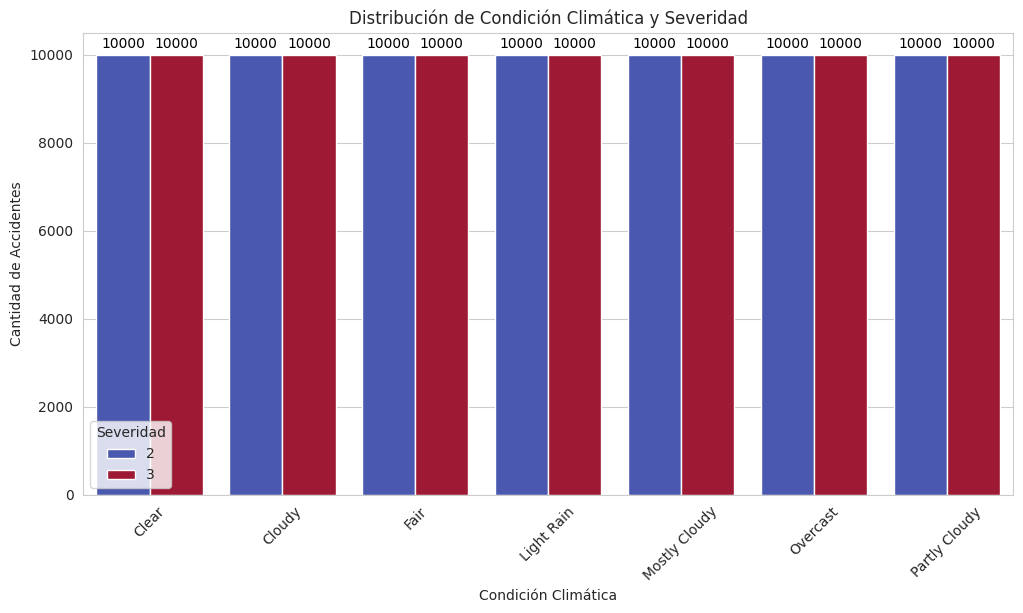

In [8]:
# Convertir a Pandas DataFrame
muestra_pd = df_muestra.select("Severity", "Weather_Condition").toPandas()

# Configuración de estilo
sns.set_style("whitegrid")

# Crear la tabla de frecuencia
tabla_frecuencia = muestra_pd.groupby(["Weather_Condition", "Severity"]).size().reset_index(name="Count")

# Crear el gráfico
plt.figure(figsize=(12, 6))
ax = sns.barplot(x="Weather_Condition", y="Count", hue="Severity", data=tabla_frecuencia, palette="coolwarm")

# Agregar los valores en cada barra
for bars in ax.containers:
    ax.bar_label(bars, fmt='%d', label_type='edge', fontsize=10, color='black', padding=3)

# Configurar etiquetas y título
plt.xticks(rotation=45)
plt.xlabel("Condición Climática")
plt.ylabel("Cantidad de Accidentes")
plt.title("Distribución de Condición Climática y Severidad")

# Ajustar la leyenda
plt.legend(title="Severidad")

# Mostrar el gráfico
plt.show()


**Etapa 2: Procesamiento y Limpieza del Conjunto de Datos**


In [9]:
# Función para obtener un resumen de valores nulos en un DataFrame de PySpark
def obten_nulos(particion):

  print(f"📊 Total de filas en la partición: \033[36m{particion.count()}\033[0m")
  print(f"🗂️ Número de columnas en la partición: \033[36m{len(particion.columns)}\033[0m")

  info_nulos = {}
  cols_nulos = {}
  total_rows = particion.count()
  registros_totales = particion.count()

  # Contar valores nulos por columna y almacenarlos en un DataFrame temporal

  cols_nulos = particion.select(
    [sum(col(c).isNull().cast("int")).alias(c) for c in particion.columns]
    )

  # Convertir los resultados en un diccionario para fácil acceso
  info_nulos = {c: cols_nulos.select(c).collect()[0][0] for c in particion.columns}

  # Filtrar solo las columnas con valores nulos y calcular el porcentaje de nulos
  cols_nulos = {c: {"count": v, "percent": (v / total_rows) * 100} for c, v in info_nulos.items() if v > 0}

  # Validar si existen columnas con valores nulos
  if not cols_nulos:
        print("✅ No existen valores nulos en la partición.")
        return

  # Crear una lista con los resultados para construir un DataFrame
  listado = [(key, value['count'], value['percent']) for key, value in cols_nulos.items()]

  # Definir el esquema del DataFrame para almacenar el resumen de valores nulos
  schema = StructType([
    StructField("Columna", StringType(), True),
    StructField("Total de nulos", IntegerType(), True),
    StructField("Porcentaje", DoubleType(), True)
  ])

  df_resumen_nulos = spark.createDataFrame(listado, schema=schema)

  for col_name in [c for c, t in df_resumen_nulos.dtypes if t == "double"]:
      df_resumen_nulos = df_resumen_nulos.withColumn(col_name, round(df_resumen_nulos[col_name], 2))

  # Ordenar el DataFrame por el número de valores nulos en orden descendente y mostrarlo en consola
  df_resumen_nulos.orderBy(col("Total de nulos").desc()).show(truncate=False)

In [10]:
# Función para imputar valores faltantes en una partición del conjunto de datos
def imputacion_valores(particion):
    print("✅ Se realiza la imputación utilizando los siguientes valores:\n")

    # Obtener las modas (valores más frecuentes) de las variables categóricas
    moda_Weather = particion.groupBy("Weather_Condition").count().orderBy(col("count").desc()).first()["Weather_Condition"]
    moda_wub = particion.groupBy("Wind_Direction").count().orderBy(col("count").desc()).first()["Wind_Direction"]
    moda_Sunset = particion.groupBy("Sunrise_Sunset").count().orderBy(col("count").desc()).first()["Sunrise_Sunset"]

    # Obtener promedios de las variables numéricas para imputación
    media_Temperature = particion.select(round(avg(col("Temperature(F)")), 2).alias("avg_temp")).collect()[0][0]
    media_Humidity = particion.select(round(avg(col("Humidity(%)")), 2).alias("avg_humidity")).collect()[0][0]
    media_Precipitation = particion.select(round(avg(col("Precipitation(in)")), 2).alias("avg_precipitation")).collect()[0][0]
    media_Pressure = particion.select(round(avg(col("Pressure(in)")), 2).alias("Pressure(in)")).collect()[0][0]
    media_Wind_Speed = particion.select(round(avg(col("Wind_Speed(mph)")), 2).alias("Wind_Speed(mph)")).collect()[0][0]

    # Imprimir valores calculados correctamente
    print(f"🌡️ Temperatura promedio: \033[36m{media_Temperature}\033[0m")
    print(f"💧 Humedad promedio: \033[36m{media_Humidity}\033[0m")
    print(f"🌧️ Precipitación promedio: \033[36m{media_Precipitation}\033[0m")
    print(f"🌬️ Velocidad del viento promedio: \033[36m{media_Wind_Speed}\033[0m")

    print(f"☁️ Condición meteorológica más frecuente: \033[36m{moda_Weather}\033[0m")
    print(f"🌬️ Dirección del viento más frecuente: \033[36m{moda_wub}\033[0m")
    print(f"🌅 Hora de atardecer más frecuente: \033[36m{moda_Sunset}\033[0m")

    # Aplicar imputación de valores numéricos con la estrategia de promedio
    imputer_num = Imputer(
         inputCols=["Temperature(F)", "Humidity(%)", "Precipitation(in)", "Wind_Speed(mph)","Pressure(in)"],
         outputCols=["Temperature(F)", "Humidity(%)", "Precipitation(in)", "Wind_Speed(mph)","Pressure(in)"]
    ).setStrategy("mean")

    particion = imputer_num.fit(particion).transform(particion)

    # Imputación de valores categóricos utilizando la moda
    particion = particion.na.fill({
        "Weather_Condition": moda_Weather,
        "Wind_Direction": moda_wub,
        "Sunrise_Sunset": moda_Sunset
    })

    print("\n🔍 Se validan nuevamente los valores nulos para corroborar la imputación.\n")

    obten_nulos(particion)

    for col_name in [c for c, t in particion.dtypes if t == "double"]:
      particion = particion.withColumn(col_name, round(particion[col_name], 1))

    return particion

In [11]:
muestra_imp = imputacion_valores(df_muestra)

✅ Se realiza la imputación utilizando los siguientes valores:



🌡️ Temperatura promedio: 65.22
💧 Humedad promedio: 69.46
🌧️ Precipitación promedio: 0.01
🌬️ Velocidad del viento promedio: 8.15
☁️ Condición meteorológica más frecuente: Cloudy
🌬️ Dirección del viento más frecuente: Calm
🌅 Hora de atardecer más frecuente: Day



🔍 Se validan nuevamente los valores nulos para corroborar la imputación.



📊 Total de filas en la partición: 140000
🗂️ Número de columnas en la partición: 16


✅ No existen valores nulos en la partición.


Para detectar valores atípicos en las columnas numéricas seleccionadas, se utiliza el método del rango intercuartílico (IQR), que permite identificar aquellos valores que se desvían del rango esperado en cada columna.

In [12]:
outliers = calcular_IQR(muestra_imp,['Precipitation(in)','Temperature(F)','Humidity(%)','Wind_Speed(mph)','Pressure(in)'])
outliers

,IQR,Límite Inf.,Límite Sup.
Columna,,,
Precipitation(in),0.0,0.00,0.00
Temperature(F),20.0,25.90,105.90
Humidity(%),30.0,11.00,131.00
Wind_Speed(mph),5.4,-3.10,18.50
Pressure(in),0.3,29.35,30.55


In [13]:
for index, row in outliers.iterrows():
    columna = index
    limite_inf = row["Límite Inf."]
    limite_sup = row["Límite Sup."]

    columnas_IQR = f"`{columna}`"

    # Aplicar una transformación a la columna para reemplazar valores atípicos
    # Si un valor está fuera de los límites establecidos, se sustituye por el promedio de la columna
    # En caso contrario, se conserva el valor original
    muestra_imp = muestra_imp.withColumn(columna, when((col(columna) < limite_inf) | (col(columna) > limite_sup), muestra_imp.selectExpr(f"avg({columnas_IQR})").collect()[0][0])
        .otherwise(col(columna))
    )


# **2 - Construcción de los *k-folds***

Una vez completado el tratamiento de los datos, imputando los valores faltantes a partir del conjunto completo de información con el fin de evitar la filtración de datos, se procede a crear k particiones, asegurando que la distribución se conserve en cada una de las tres particiones.


In [14]:
from pyspark.sql.window import Window
from pyspark.sql.functions import percent_rank

window_spec = Window.partitionBy("Weather_Condition").orderBy(rand())

# Agregar ranking porcentual
df_indexed = muestra_imp.withColumn("rank", percent_rank().over(window_spec))

# Filtrar registros en tercios
df1 = df_indexed.filter(col("rank") <= 1/3).drop("rank")
df2 = df_indexed.filter((col("rank") > 1/3) & (col("rank") <= 2/3)).drop("rank")
df3 = df_indexed.filter(col("rank") > 2/3).drop("rank")



In [15]:
total_df1 = df1.count()
total_df2 = df2.count()
total_df3 = df3.count()
total_registros = total_df1 + total_df2 + total_df3

print("\033[1mResumen de Particiones\033[0m")
print("=" * 55)
print(f"🔹 Partición 1: \033[36m{total_df1}\033[0m Registros — Distribución: \033[36m{(total_df1/total_registros)*100:.2f}%\033[0m")
print(f"🔹 Partición 2: \033[36m{total_df2}\033[0m Registros — Distribución: \033[36m{(total_df2/total_registros)*100:.2f}%\033[0m")
print(f"🔹 Partición 3: \033[36m{total_df3}\033[0m Registros — Distribución: \033[36m{(total_df3/total_registros)*100:.2f}%\033[0m")
print("=" * 55)

Resumen de Particiones
🔹 Partición 1: 46669 Registros — Distribución: 33.34%
🔹 Partición 2: 46662 Registros — Distribución: 33.33%
🔹 Partición 3: 46669 Registros — Distribución: 33.34%


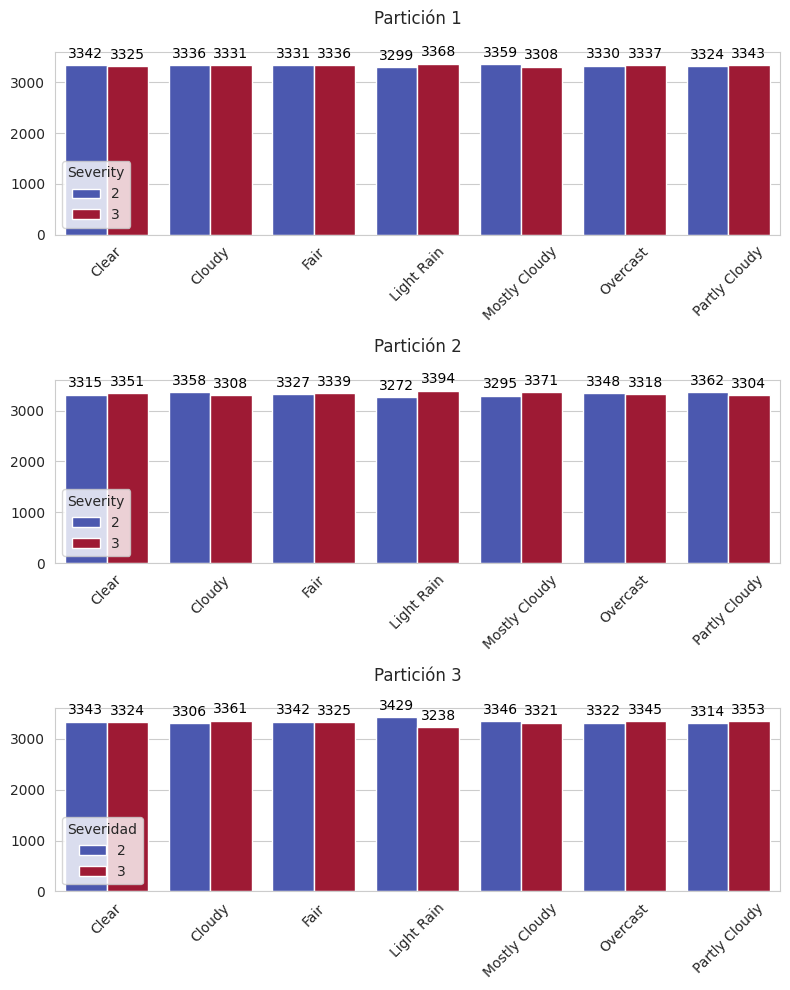

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

# Lista de DataFrames a graficar
dfs = [df1, df2, df3]
titulos = ["Partición 1", "Partición 2", "Partición 3"]

# Configuración de estilo
sns.set_style("whitegrid")

# Crear las gráficas en una figura de subplots
fig, axes = plt.subplots(3, 1, figsize=(8, 10), sharey=True)

for i, (df, titulo) in enumerate(zip(dfs, titulos)):
    # Convertir a Pandas DataFrame
    muestra_pd = df.select("Severity", "Weather_Condition").toPandas()

    # Crear la tabla de frecuencia
    tabla_frecuencia = muestra_pd.groupby(["Weather_Condition", "Severity"]).size().reset_index(name="Count")

    # Crear el gráfico en el subplot correspondiente
    ax = sns.barplot(x="Weather_Condition", y="Count", hue="Severity", data=tabla_frecuencia, palette="coolwarm", ax=axes[i])

    # Agregar los valores en cada barra
    for bars in ax.containers:
        ax.bar_label(bars, fmt='%d', label_type='edge', fontsize=10, color='black', padding=3)

    # Configurar etiquetas y título
    ax.set_xticks(range(len(ax.get_xticklabels())))
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    ax.set(xlabel=None,ylabel=None)
    ax.set_title(titulo, pad=20)

# Ajustar la leyenda
axes[2].legend(title="Severidad")  # Solo en la última gráfica para evitar repetición

# Mostrar el conjunto de gráficos
plt.tight_layout()
plt.show()

# **3 - Experimentación**

In [17]:
df1.show(5)

+--------------+-----------------+--------+-----------+------------+--------------+---------------+-----------------+--------+--------+-------+----------+-----+--------------+---------------+--------------+
|Temperature(F)|Weather_Condition|Severity|Humidity(%)|Pressure(in)|Wind_Direction|Wind_Speed(mph)|Precipitation(in)|Crossing|Junction|Railway|Roundabout| Stop|Sunrise_Sunset|Traffic_Calming|Traffic_Signal|
+--------------+-----------------+--------+-----------+------------+--------------+---------------+-----------------+--------+--------+-------+----------+-----+--------------+---------------+--------------+
|          69.1|            Clear|       3|       57.0|        30.0|         North|           11.5|              0.0|   false|   false|  false|     false|false|           Day|          false|         false|
|          57.9|            Clear|       2|       84.0|        30.1|            SE|            4.6|              0.0|   false|   false|  false|     false|false|         Nig

**Generación de Vectores de Características**

Se crea el vector de características utilizando RFormula, que permite transformar los datos de manera estructurada para su uso en modelos de aprendizaje automático.

In [18]:
# "Severity ~ ." indica que 'Severity' es la variable dependiente y el resto son predictoras
rForm = RFormula(formula="Severity ~ .")

muestra_RF1 = rForm.fit(df1)
rf_1 = muestra_RF1.transform(df1)

muestra_RF2 = rForm.fit(df2)
rf_2 = muestra_RF2.transform(df2)

muestra_RF3 = rForm.fit(df3)
rf_3 = muestra_RF3.transform(df3)


In [19]:
# Combinar rf_1 con rf_2
rf_1_2 = rf_1.union(rf_2)

# Combinar rf_1 con rf_3
rf_1_3 = rf_1.union(rf_3)

# Combinar rf_2 con rf_3
rf_2_3 = rf_2.union(rf_3)


**Construcción Train – Test**

In [20]:
train_1_2, test_1_2 = rf_1_2.randomSplit([0.7, 0.3], seed=42)
train_1_3, test_1_3 = rf_1_3.randomSplit([0.7, 0.3], seed=42)
train_2_3, test_2_3 = rf_2_3.randomSplit([0.7, 0.3], seed=42)

In [21]:
# 📊 Evaluador de Accuracy
# Mide el porcentaje de predicciones correctas sobre el total de instancias.
accuracy = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")

# 🎯 Evaluador de Precision Ponderada
# Evalúa qué tan preciso es el modelo en la clasificación de cada categoría.
# Considera la cantidad de falsos positivos y ajusta el cálculo según el peso de cada clase.
precision = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedPrecision")

# 🔄 Evaluador de Recall Ponderado
# Mide cuántas instancias de cada clase fueron correctamente identificadas por el modelo.
# Es útil para conocer qué tan bien reconoce la presencia de cada categoría.
recall = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedRecall")

# ⚖ Evaluador de F1-Score
# Combina precisión y recall en una sola métrica, proporcionando un equilibrio entre ambos.
# Ideal para evaluar modelos cuando hay clases desbalanceadas
f1_score = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")

In [22]:
# 🌳 Definición del modelo Random Forest Classifier
# Se establece el modelo con los mejores hiperparámetros obtenidos
# mediante validación cruzada, optimizando su rendimiento.
rf = RandomForestClassifier(
    featuresCol='features',
    labelCol='label',
    numTrees=50,
    maxDepth=15,
    featureSubsetStrategy= 'auto' ,
    impurity= 'entropy',
    subsamplingRate= 1.0
)

In [23]:
# 🏋️ Entrenar el modelo con el conjunto de entrenamiento
rf_1 = rf.fit(train_1_2)
rf_2 = rf.fit(train_1_3)
rf_3 = rf.fit(train_2_3)

# **4 - Resultados**

In [115]:
# 📊 Evaluación del rendimiento del modelo en los diferentes métodos de muestreo

# 🎯 Calcular Accuracy (precisión global)
acc_1 = accuracy.evaluate(rf_1.transform(test_1_2))
acc_2 = accuracy.evaluate(rf_2.transform(test_1_3))
acc_3 = accuracy.evaluate(rf_3.transform(test_2_3))

# 🔍 Calcular Precision (qué tan exactas son las predicciones positivas)
precision_1 = precision.evaluate(rf_1.transform(test_1_2))
precision_2 = precision.evaluate(rf_1.transform(test_1_3))
precision_3 = precision.evaluate(rf_1.transform(test_2_3))

# 🚀 Calcular Recall (qué tan bien se identifican los positivos)
recall_1 = recall.evaluate(rf_1.transform(test_1_2))
recall_2 = recall.evaluate(rf_1.transform(test_1_3))
recall_3 = recall.evaluate(rf_1.transform(test_2_3))


# ⚖ Calcular F1-Score (balance entre precisión y recall)
f1_1 = f1_score.evaluate(rf_1.transform(test_1_2))
f1_2 = f1_score.evaluate(rf_1.transform(test_1_3))
f1_3 = f1_score.evaluate(rf_1.transform(test_2_3))

listado_Acc = [acc_1, acc_2, acc_3]
listado_Pre = [precision_1, precision_2, precision_3]
listado_Rec = [recall_1, recall_2, recall_3]
listado_f1 = [f1_1, f1_2, f1_3]

mean_acc = np.mean(listado_Acc)
mean_pre = np.mean(listado_Pre)
mean_rec = np.mean(listado_Rec)
mean_f1 = np.mean(listado_f1)

std_acc = np.std(listado_Acc)
std_pre = np.std(listado_Pre)
std_rec = np.std(listado_Rec)
std_f1 = np.std(listado_f1)

In [128]:
def plot_tendencia(etiquetas,valores,mean,std):
  plt.figure(figsize=(6, 3))
  plt.plot(etiquetas, valores, marker='o', linestyle='-', color='purple', label="Valores")
  plt.axhline(y=mean, color='black', linestyle='--', label=f'Promedio ({mean:.4f})')
  plt.fill_between(etiquetas, mean - std, mean + std, color='gray', alpha=0.2, label=f'DE ({std:.4f})')

  for i, val in enumerate(valores):
    plt.text(etiquetas[i], val, f"{val:.4f}", ha='center', va='bottom', fontsize=10, color="black")

  plt.legend(loc='lower right')
  plt.show()

🎯 Evaluación del Modelo: Comparación de Accuracy 🎯

✅ Accuracy - 1: 0.6338
✅ Accuracy - 2: 0.6344
✅ Accuracy - 3: 0.6369
Promedio: 0.635069
Desviación estándar: 0.001333


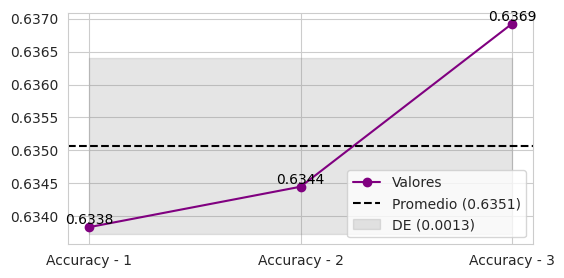

🎯 Evaluación del Modelo: Comparación de Precisión 🔍

🎯 Precisión - 1: 0.6735
🎯 Precisión - 2: 0.6768
🎯 Precisión - 3: 0.6907
Promedio: 0.680330
Desviación estándar: 0.007445


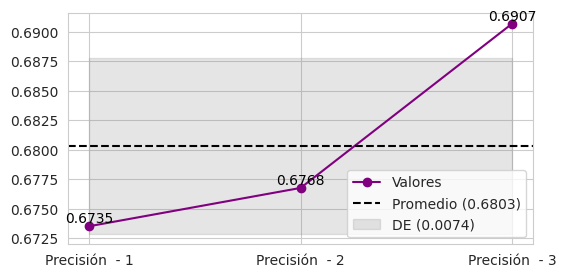

🚀 Evaluación del Modelo: Comparación de Recall 🚀

🔥 Recall - 1: 0.6338
🔥 Recall - 2: 0.6338
🔥 Recall - 3: 0.6456
Promedio: 0.637747
Desviación estándar: 0.005579


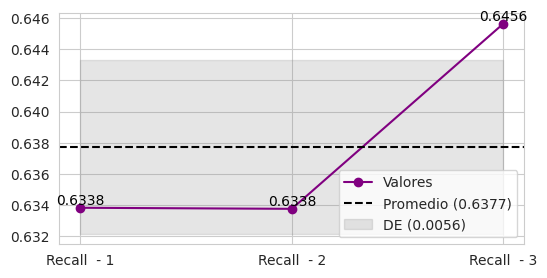

⚖ Evaluación del Modelo: Comparación de F1-Score ⚖

⚡ F1-Score - 1: 0.6107
⚡ F1-Score - 2: 0.6096
⚡ F1-Score - 3: 0.6224
Promedio: 0.614243
Desviación estándar: 0.005782


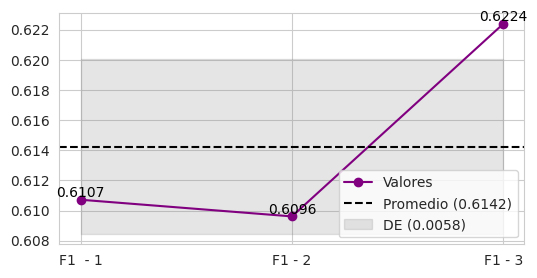

In [136]:
print("🎯 Evaluación del Modelo: Comparación de Accuracy 🎯\n")
# 🎯 Accuracy
print(f"✅ Accuracy - 1: \033[36m{acc_1:.4f}\033[0m")
print(f"✅ Accuracy - 2: \033[36m{acc_2:.4f}\033[0m")
print(f"✅ Accuracy - 3: \033[36m{acc_3:.4f}\033[0m")
print(f"Promedio: \033[32m{mean_acc:4f}\033[0m")
print(f"Desviación estándar: \033[32m{std_acc:4f}\033[0m")
labels = ["Accuracy - 1", "Accuracy - 2", "Accuracy - 3"]
plot_tendencia(labels,listado_Acc,mean_acc,std_acc)
print("=" * 80)
print("🎯 Evaluación del Modelo: Comparación de Precisión 🔍\n")
# 🎯 Precision
print(f"🎯 Precisión - 1: \033[36m{precision_1:.4f}\033[0m")
print(f"🎯 Precisión - 2: \033[36m{precision_2:.4f}\033[0m")
print(f"🎯 Precisión - 3: \033[36m{precision_3:.4f}\033[0m")
print(f"Promedio: \033[32m{mean_pre:4f}\033[0m")
print(f"Desviación estándar: \033[32m{std_pre:4f}\033[0m")
labels = ["Precisión  - 1", "Precisión  - 2", "Precisión  - 3"]
plot_tendencia(labels,listado_Pre,mean_pre,std_pre)
print("=" * 80)
print("🚀 Evaluación del Modelo: Comparación de Recall 🚀\n")
# 🔥 Recall
print(f"🔥 Recall - 1: \033[36m{recall_1:.4f}\033[0m")
print(f"🔥 Recall - 2: \033[36m{recall_2:.4f}\033[0m")
print(f"🔥 Recall - 3: \033[36m{recall_3:.4f}\033[0m")
print(f"Promedio: \033[32m{mean_rec:4f}\033[0m")
print(f"Desviación estándar: \033[32m{std_rec:4f}\033[0m")
labels = ["Recall  - 1", "Recall  - 2", "Recall  - 3"]
plot_tendencia(labels,listado_Rec,mean_rec,std_rec)
print("=" * 80)
print("⚖ Evaluación del Modelo: Comparación de F1-Score ⚖\n")
# ⚡ F1-Score
print(f"⚡ F1-Score - 1: \033[36m{f1_1:.4f}\033[0m")
print(f"⚡ F1-Score - 2: \033[36m{f1_2:.4f}\033[0m")
print(f"⚡ F1-Score - 3: \033[36m{f1_3:.4f}\033[0m")
print(f"Promedio: \033[32m{mean_f1:4f}\033[0m")
print(f"Desviación estándar: \033[32m{std_f1:4f}\033[0m")
labels = ["F1  - 1", "F1 - 2", "F1 - 3"]
plot_tendencia(labels,listado_f1,mean_f1,std_f1)
print("=" * 58)

# **5 - Discusión y conclusiones**